In [3]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
from google.cloud import storage
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import pickle
import os
import io

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/harshsingh/Documents/Loblaw-case-study/key.json"

In [5]:
bucket_name = 'loblaw-bucket'
prefix = 'raw'

feature_folder_name = 'processed/feature'  
feature_file_name = 'sales-feature.parquet'
pickle_folder_name ='models' 

In [6]:
client = storage.Client()
bucket = client.get_bucket(bucket_name)

In [7]:
def download_blob(folder_name, file_name):
    object_path = f'{folder_name}/{file_name}'
    blob = bucket.blob(object_path)
    
    buffer = io.BytesIO()
    # Download blob data into the buffer
    blob.download_to_file(buffer)
    
    buffer.seek(0)
    df = pd.read_parquet(buffer)

    return df

In [8]:
def upload_pkl(model,folder_name, file_name):
    
    object_path = f'{folder_name}/{file_name}'
    
    blob = bucket.blob(object_path)
    
    buffer = io.BytesIO()
    pickle.dump(model, buffer)
    buffer.seek(0)

    blob.upload_from_file(buffer)



In [9]:
# identifying top products
def identify_top_products(df, top_n=5):

    product_sales = df.groupby('product').agg(
        total_value=('total_price', 'sum'),
        total_quantity=('quantity', 'sum')
    ).sort_values('total_value', ascending=False).head(top_n)
    
    return product_sales.index.tolist()


In [10]:
def prepare_product_features(df, product_name):

    # Filtering data for specific product
    product_df = df[df['product'] == product_name].copy()
    
    return product_df

In [11]:
def time_series_train_test_split(data, test_size=0.2):

    split_idx = int(len(data) * (1 - test_size))
    train = data.iloc[:split_idx].copy()
    test = data.iloc[split_idx:].copy()
    
    return train, test

In [ ]:
def build_and_evaluate_model(train_data, test_data, target_col='daily_quantity'):

    # Define features and target
    feature_cols = ['day_of_week', 'month', 'day', 'lag_1_quantity', 
                    'lag_7_quantity', 'lag_30_quantity', 'rolling_7d_mean', 
                    'rolling_30d_mean']
    
    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    
    X_test = test_data[feature_cols]
    y_test = test_data[target_col]
    
    # Define models to test
    models = {
        'LinearRegression': LinearRegression(),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    best_model = None
    best_score = float('-inf')
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        # Fit model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }
        
        # Track best model
        if r2 > best_score:
            best_score = r2
            best_model = model
    
    # Return evaluation results and best model
    return results, best_model

In [13]:
def visualize_predictions(test_data, predictions, product_name):

    plt.figure(figsize=(12, 6))
    plt.plot(test_data['order_date'], test_data['daily_quantity'], label='Actual', marker='o')
    plt.plot(test_data['order_date'], predictions, label='Predicted', marker='x')
    plt.title(f'Sales Quantity Prediction for {product_name}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    return plt

In [ ]:
def analyze_feature_importance(model, feature_names):

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importance')
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        
        return plt, pd.DataFrame({
            'Feature': [feature_names[i] for i in indices],
            'Importance': importances[indices]
        })
    else:
        return None, None

In [15]:
# Main function to run the entire pipeline for each product
def predict_sales_for_top_products(df, top_products=None):
    
    if top_products is None:
        top_products = identify_top_products(df)
    
    product_models = {}
    
    
    for product in top_products:
        print(f"Building model for: {product}")
        
       
        product_data = prepare_product_features(df, product)
        
        train_data, test_data = time_series_train_test_split(product_data)
        
        
        results, best_model = build_and_evaluate_model(train_data, test_data)
        
        # Make predictions with the best model
        feature_cols = ['day_of_week', 'month', 'day', 'lag_1_quantity', 
                        'lag_7_quantity', 'lag_30_quantity', 'rolling_7d_mean', 
                        'rolling_30d_mean']
        predictions = best_model.predict(test_data[feature_cols])
        
        # Visualize predictions
        # pred_plot = visualize_predictions(test_data, predictions, product)
        
        importance_plot, importance_df = analyze_feature_importance(best_model, feature_cols)
        
        # Storing results
        product_models[product] = {
            'model': best_model,
            'evaluation': results,
            'feature_importance': importance_df,
            'test_data': test_data,
            'predictions': predictions
        }
        file_name= f"{product.replace(' ', '_')}_sales_model.pkl"
        # Save the best model
        upload_pkl(best_model, folder_name=pickle_folder_name, file_name= file_name)
        # To save in local
        #joblib.dump(best_model, f"{product.replace(' ', '_')}_sales_model.pkl")
    
    return product_models

In [16]:
download_df = download_blob(feature_folder_name,feature_file_name)

Building model for: Macbook Pro Laptop
Building model for: iPhone
Building model for: ThinkPad Laptop
Building model for: Google Phone
Building model for: 27in 4K Gaming Monitor


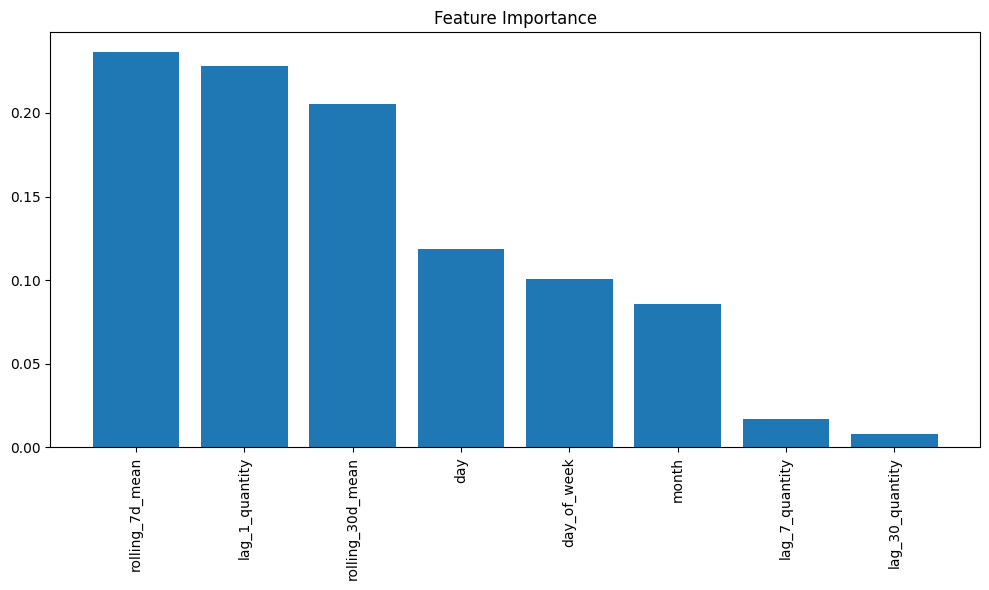

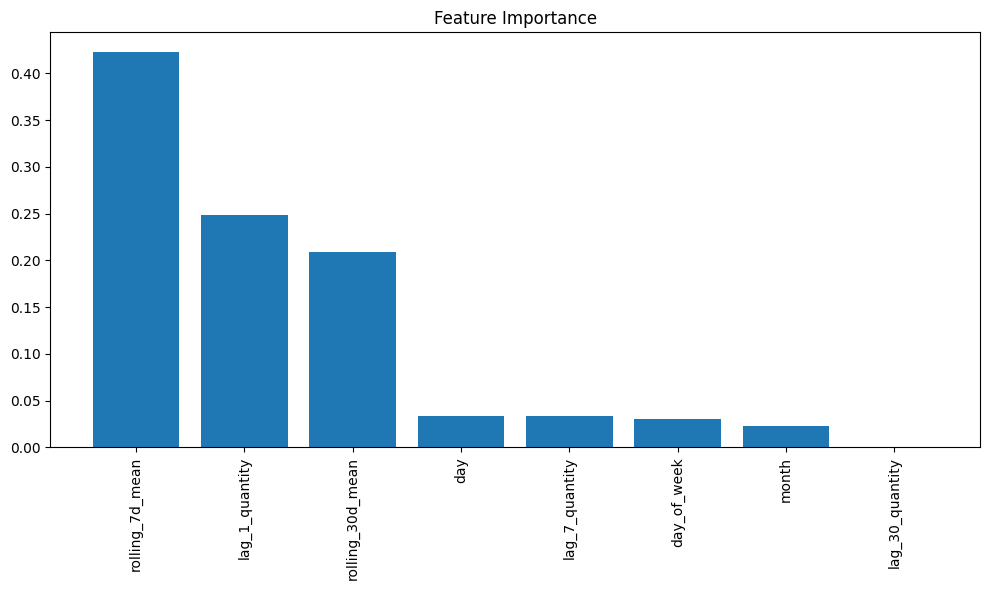

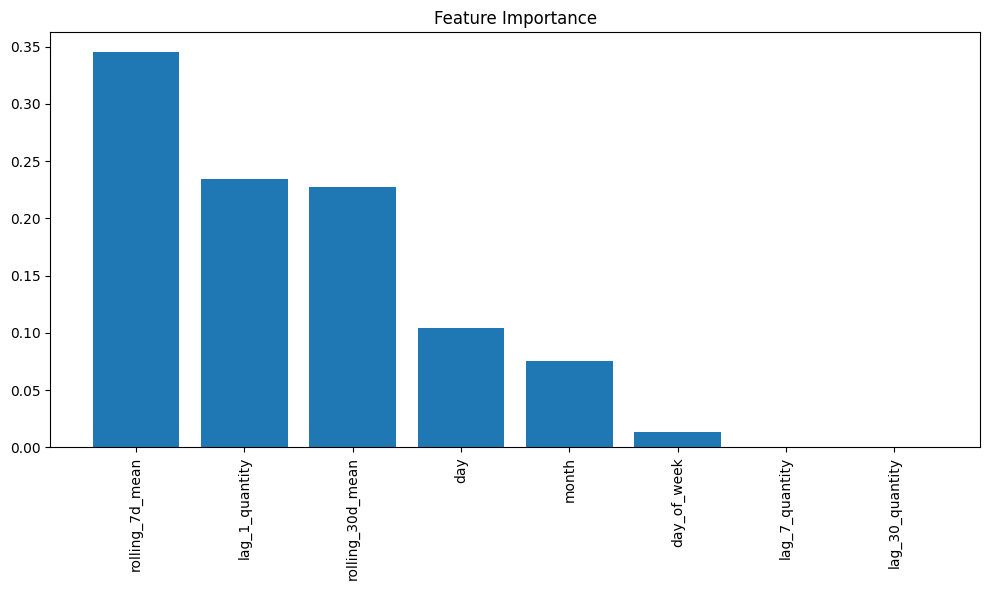

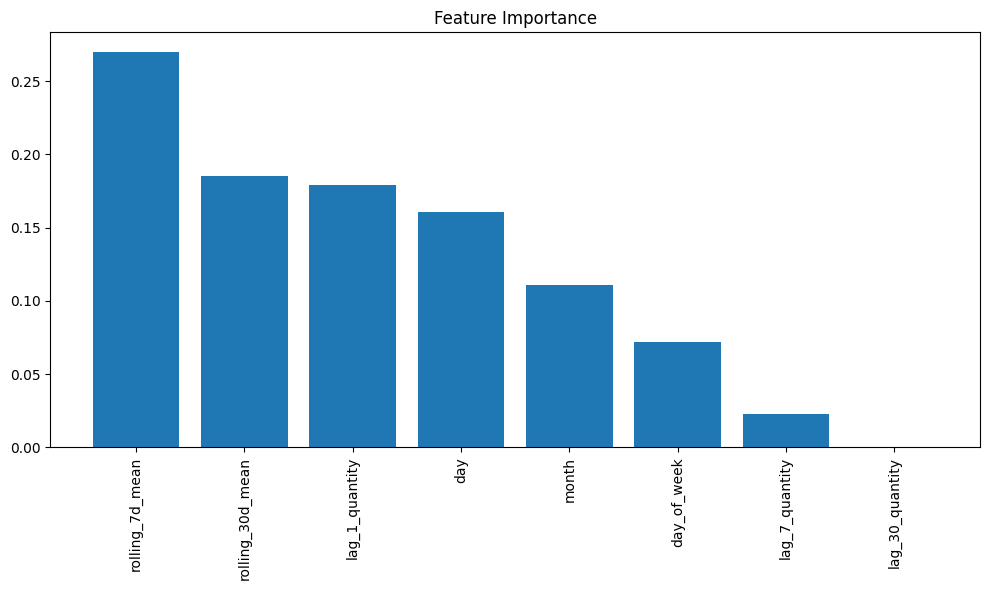

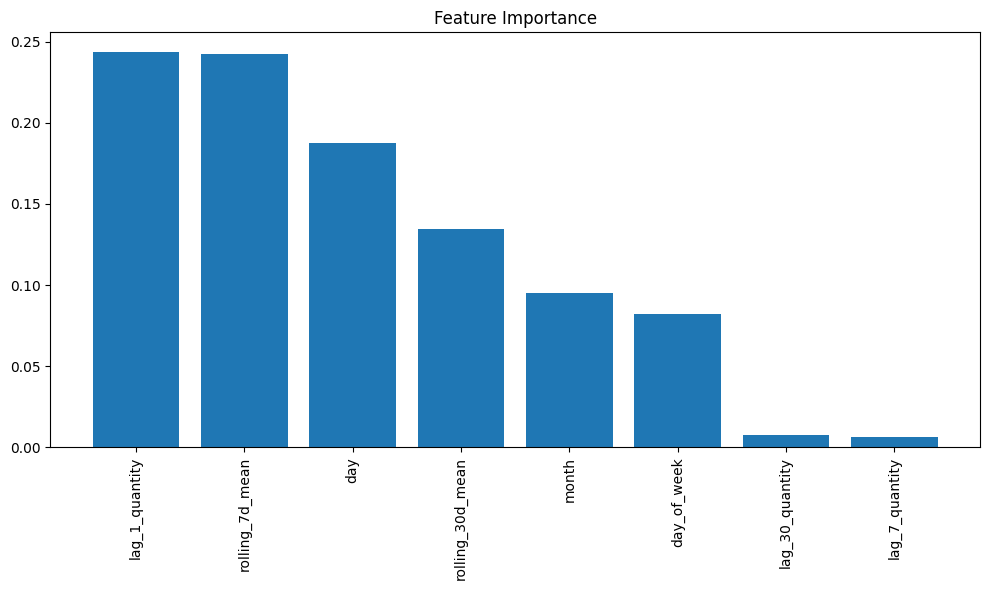

In [17]:
# Run the pipeline
product_models = predict_sales_for_top_products(download_df, identify_top_products(download_df))

In [18]:
product_models['Macbook Pro Laptop']

{'model': RandomForestRegressor(random_state=42),
 'evaluation': {'LinearRegression': {'model': LinearRegression(),
   'RMSE': np.float64(0.0806486757410325),
   'MAE': 0.014868421584769526,
   'R2': 0.2300083815194487},
  'RandomForest': {'model': RandomForestRegressor(random_state=42),
   'RMSE': np.float64(0.05716072784080031),
   'MAE': 0.006022237435975456,
   'R2': 0.6131995089000288},
  'GradientBoosting': {'model': GradientBoostingRegressor(random_state=42),
   'RMSE': np.float64(0.05924149284851904),
   'MAE': 0.009242959041664124,
   'R2': 0.5845263317424898}},
 'feature_importance':             Feature  Importance
 0   rolling_7d_mean    0.236427
 1    lag_1_quantity    0.228330
 2  rolling_30d_mean    0.205494
 3               day    0.118459
 4       day_of_week    0.100554
 5             month    0.085879
 6    lag_7_quantity    0.017069
 7   lag_30_quantity    0.007787,
 'test_data':                   product  quantity  each_price          order_date  month  \
 63160  Ma

In [31]:
product_models['iPhone']

{'model': GradientBoostingRegressor(random_state=42),
 'evaluation': {'LinearRegression': {'model': LinearRegression(),
   'RMSE': np.float64(0.1445742477038786),
   'MAE': 0.04091151173914382,
   'R2': 0.24853000224265764},
  'RandomForest': {'model': RandomForestRegressor(random_state=42),
   'RMSE': np.float64(0.11953443651210366),
   'MAE': 0.024370211897744937,
   'R2': 0.4862925771180452},
  'GradientBoosting': {'model': GradientBoostingRegressor(random_state=42),
   'RMSE': np.float64(0.11182908362142473),
   'MAE': 0.02636726480183344,
   'R2': 0.5503865482852566}},
 'feature_importance':             Feature  Importance
 0   rolling_7d_mean    0.422831
 1    lag_1_quantity    0.248140
 2  rolling_30d_mean    0.208959
 3               day    0.033981
 4    lag_7_quantity    0.033245
 5       day_of_week    0.030134
 6             month    0.022405
 7   lag_30_quantity    0.000305,
 'test_data':        product  quantity  each_price          order_date  month  day_of_week  \
 1539

In [32]:
product_models['ThinkPad Laptop']

{'model': GradientBoostingRegressor(random_state=42),
 'evaluation': {'LinearRegression': {'model': LinearRegression(),
   'RMSE': np.float64(0.09389147181987018),
   'MAE': 0.01638563820699097,
   'R2': 0.26819566144577855},
  'RandomForest': {'model': RandomForestRegressor(random_state=42),
   'RMSE': np.float64(0.06379494467857849),
   'MAE': 0.007936105053483102,
   'R2': 0.662156773394637},
  'GradientBoosting': {'model': GradientBoostingRegressor(random_state=42),
   'RMSE': np.float64(0.059402787605093696),
   'MAE': 0.007723046440237239,
   'R2': 0.7070750683651791}},
 'feature_importance':             Feature  Importance
 0   rolling_7d_mean    0.345220
 1    lag_1_quantity    0.234164
 2  rolling_30d_mean    0.227238
 3               day    0.103946
 4             month    0.075667
 5       day_of_week    0.013139
 6    lag_7_quantity    0.000627
 7   lag_30_quantity    0.000000,
 'test_data':                 product  quantity  each_price          order_date  month  \
 175481

In [33]:
product_models['Google Phone']

{'model': RandomForestRegressor(random_state=42),
 'evaluation': {'LinearRegression': {'model': LinearRegression(),
   'RMSE': np.float64(0.13932422457867732),
   'MAE': 0.036330869896430855,
   'R2': 0.24444361762475264},
  'RandomForest': {'model': RandomForestRegressor(random_state=42),
   'RMSE': np.float64(0.10196326083138592),
   'MAE': 0.019458467096547173,
   'R2': 0.5953299703863123},
  'GradientBoosting': {'model': GradientBoostingRegressor(random_state=42),
   'RMSE': np.float64(0.10331064528878692),
   'MAE': 0.022637740435291518,
   'R2': 0.5845643542821146}},
 'feature_importance':             Feature  Importance
 0   rolling_7d_mean    0.269733
 1  rolling_30d_mean    0.185380
 2    lag_1_quantity    0.178824
 3               day    0.160664
 4             month    0.110819
 5       day_of_week    0.072024
 6    lag_7_quantity    0.022557
 7   lag_30_quantity    0.000000,
 'test_data':             product  quantity  each_price          order_date  month  \
 39490  Google

In [34]:
product_models['27in 4K Gaming Monitor']

{'model': RandomForestRegressor(random_state=42),
 'evaluation': {'LinearRegression': {'model': LinearRegression(),
   'RMSE': np.float64(0.13783810125298762),
   'MAE': 0.0386421519558347,
   'R2': 0.26714183799587143},
  'RandomForest': {'model': RandomForestRegressor(random_state=42),
   'RMSE': np.float64(0.11195676010383501),
   'MAE': 0.024168381031577157,
   'R2': 0.5165161084394505},
  'GradientBoosting': {'model': GradientBoostingRegressor(random_state=42),
   'RMSE': np.float64(0.11581384084828876),
   'MAE': 0.026542224406170007,
   'R2': 0.4826287463439404}},
 'feature_importance':             Feature  Importance
 0    lag_1_quantity    0.243595
 1   rolling_7d_mean    0.242549
 2               day    0.187712
 3  rolling_30d_mean    0.134610
 4             month    0.095064
 5       day_of_week    0.082413
 6   lag_30_quantity    0.007827
 7    lag_7_quantity    0.006231,
 'test_data':                       product  quantity  each_price          order_date  \
 90635  27in 